In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from ode_solve import adaptive_RK

In [2]:
"""cascade reaction A→P→S"""
k1 = lambda T: 8.e15 * np.exp(-133.024 / 8.314e-3 / T)  # 1/s
k2 = lambda T: 0.5e20 * np.exp(-173.5 / 8.314e-3 / T)  # 1/s
dH1 = -1.2e8 # J/kmol
dH2 = -1.18e8  # J/kmol

CA0 = 3.0  # kmol/m3
CP0 = 0.0
CS0 = 0.0
VR = 2.37  # m3
v = 1.905e-3  # m3/s
T0 = 333.15  # K
rho = 1000  # kg/m3
Cp = 4000  # J/(kg*K)
Tc = 360.
UA = 13000  # J/(s*K)

In [3]:
def Q_gen(CA, CP, T):
    return -(dH1 * k1(T) * CA + dH2 * k2(T) * CP) * VR


def Q_rem(T):
    return (T - T0) * v * rho * Cp + UA * (T - Tc)


def dydt(y):
    CA, CP, CS, T = y
    kCA = (CA0 - CA) * v / VR - k1(T) * CA
    kCP = (CP0 - CP) * v / VR - k2(T) * CP + k1(T) * CA
    kCS = (CS0 - CS) * v / VR + k2(T) * CP
    kT = (Q_gen(CA, CP, T) - Q_rem(T)) / (VR * rho * Cp)
    return np.array([kCA, kCP, kCS, kT])

CAs = lambda T: CA0 / (1 + k1(T) * VR / v)
CPs = lambda T: (v * CP0 + (k1(T) * CA0 * v * VR / (k1(T) * VR + v))) / (k2(T) * VR + v)

In [4]:
t_max = 100000
dt = 1.0

n = 5
T_lim = 300, 550
initials = np.array([[T0, CA0, CP0]]).repeat(n, axis=0)
initials = np.append(initials, np.zeros((n, 3)), axis=0)
initials[:n, 0] = np.linspace(T_lim[0], 500, n)
initials[n:, 0] = np.linspace(T_lim[0], 500, n)

Ts = np.zeros(2)
for i, x0 in enumerate([370., 420]):
    sol = opt.root(lambda T: Q_gen(CAs(T), CPs(T), T) - Q_rem(T),
                   x0=x0).x[0]
    initials = np.append(initials,
                         np.array([[sol - 0.1, CAs(sol), CPs(sol)]]),
                         axis=0)
    Ts[i] = sol
print(f'Ts = {Ts[0]:.2f} K, {Ts[1]:.2f} K')

paths = []
Q_gen_list = []

for val in initials:
    t = np.zeros(1)
    T = np.array([val[0]])
    CA = np.array([val[1]])
    CP = np.array([val[2]])
    CS = np.array([0.])
    Q_gen_transient = Q_gen(CA[-1], CP[-1], T[-1])

    while t[-1] < t_max:
        y0 = np.array([CA[-1], CP[-1], CS[-1], T[-1]])
        y, dt, dt_new = adaptive_RK(dydt, y0, dt=dt, tol=1e-8)
        CA_new, CP_new, CS_new, T_new = y

        t = np.append(t, t[-1] + dt)
        CA = np.append(CA, CA_new)
        CP = np.append(CP, CP_new)
        CS = np.append(CS, CS_new)
        T = np.append(T, T_new)
        Q_gen_transient = np.append(Q_gen_transient, Q_gen(CA_new, CP_new, T_new))

        if T_new > T_lim[1]: break
        print(f'\rt = {t[-1]:.2f} s, CA = {CA[-1]:.3f} kmol/m3, CP = {CP[-1]:.3f} kmol/m3, '
              f'T = {T[-1]:.2f} K, dt = {dt:.2e} s', end='')
        dt = dt_new

    xyz = np.concatenate((T, CA, CP, CS)).reshape((4, -1))
    paths.append(xyz)
    Q_gen_list.append(Q_gen_transient)

Ts = 380.86 K, 409.87 K
t = 100000.76 s, CA = 0.004 kmol/m3, CP = 0.048 kmol/m3, T = 430.59 K, dt = 4.38e+00 s

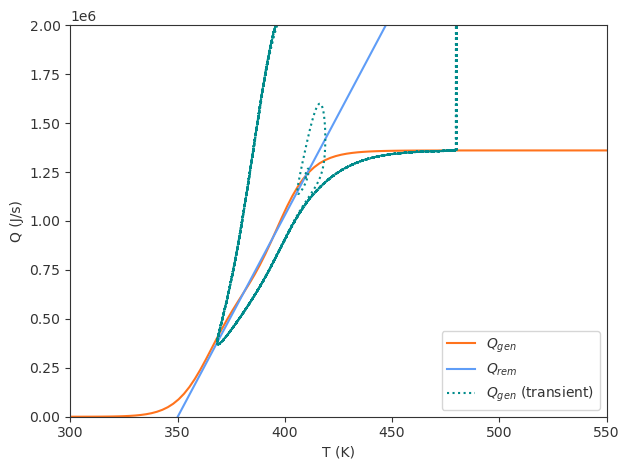

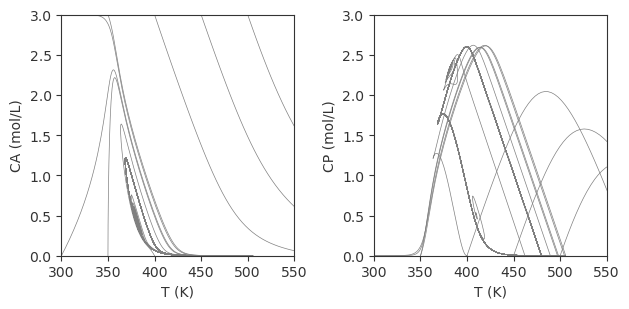

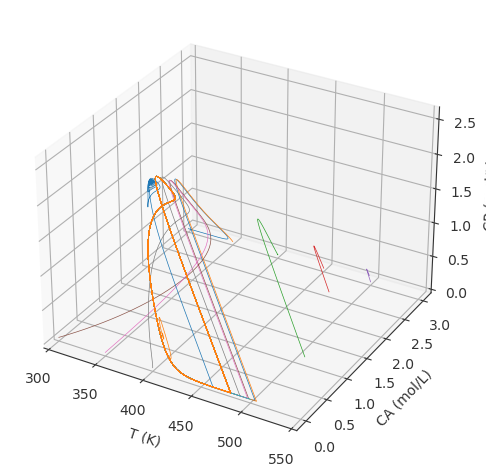

In [5]:
"""plots"""
text_color = '#333333'
plt.rcParams.update({
    'text.color': text_color,
    'axes.labelcolor': text_color,
    'axes.edgecolor': text_color,
    'xtick.color': text_color,
    'ytick.color': text_color,
})

fig_QT = plt.figure(1, layout='tight')
fig_CT = plt.figure(2, figsize=(6.4, 3.2), layout='tight')
fig_phase3d = plt.figure(3, layout='tight')
ax_QT = fig_QT.add_subplot()
ax_CT1 = fig_CT.add_subplot(121)
ax_CT2 = fig_CT.add_subplot(122)
ax_phase3d = fig_phase3d.add_subplot(projection='3d')

Ts = np.linspace(*T_lim, 100)
ax_QT.plot(Ts, Q_gen(CAs(Ts), CPs(Ts), Ts), color='#FF731D', label='$Q_{gen}$')
ax_QT.plot(Ts, Q_rem(Ts), color='#5F9DF7', label='$Q_{rem}$')
ax_QT.plot(paths[-1][0], Q_gen_list[-1], ':', color='darkcyan', label='$Q_{gen}$ (transient)')
ax_QT.legend(loc='lower right')
ax_QT.set(xlabel='T (K)', ylabel='Q (J/s)',
          xlim=T_lim, ylim=(0, 2e6))
ax_QT.ticklabel_format(axis='y', scilimits=[-3, 3])

for xyz in paths:
    # C_total = xyz[1:].sum(axis=0)
    T, CA, CP, CS = xyz
    ax_CT1.plot(T, CA, linewidth=0.5, color='gray')
    ax_CT2.plot(T, CP, linewidth=0.5, color='gray')

    xyz = np.concatenate((T, CA, CP)).reshape((3, -1))
    ax_phase3d.plot(*xyz, linewidth=0.5)
ax_CT1.set(xlabel='T (K)', ylabel='CA (mol/L)', xlim=T_lim, ylim=(0, CA0))
ax_CT2.set(xlabel='T (K)', ylabel='CP (mol/L)', xlim=T_lim, ylim=(0, CA0))
ax_phase3d.set(xlabel='T (K)', ylabel='CA (mol/L)', zlabel='CP (mol/L)',
               xlim=T_lim)
plt.show()
# %matplotlib